In [2]:
# Pairs
import pandas as pd

In [6]:
df = pd.read_csv("human_lr_pair.txt", sep = "\s+")
df

,lr_pair,ligand_gene_symbol,receptor_gene_symbol,ligand_gene_id,receptor_gene_id,ligand_ensembl_protein_id,receptor_ensembl_protein_id,ligand_ensembl_gene_id,receptor_ensembl_gene_id,evidence
0,SEMA3F_PLXNA3,SEMA3F,PLXNA3,6405,55558,ENSP00000002829,ENSP00000358696,ENSG00000001617,ENSG00000130827,15721238
1,SEMA3F_PLXNA1,SEMA3F,PLXNA1,6405,5361,ENSP00000002829,ENSP00000377061,ENSG00000001617,ENSG00000114554,26156437
2,SEMA3F_NRP1,SEMA3F,NRP1,6405,8829,ENSP00000002829,ENSP00000265371,ENSG00000001617,ENSG00000099250,9883722
3,SEMA3F_NRP2,SEMA3F,NRP2,6405,8828,ENSP00000002829,ENSP00000353582,ENSG00000001617,ENSG00000118257,15721238
4,CX3CL1_CX3CR1,CX3CL1,CX3CR1,6376,1524,ENSP00000006053,ENSP00000351059,ENSG00000006210,ENSG00000168329,"10699158,24218476"
...,...,...,...,...,...,...,...,...,...,...
3393,CGA_GPR84,CGA,GPR84,1081,53831,ENSP00000482232,ENSP00000450310,ENSG00000135346,ENSG00000139572,32196115
3394,ASIP_MC1R,ASIP,MC1R,434,4157,ENSP00000454804,ENSP00000451605,ENSG00000101440,ENSG00000258839,12851328
3395,VEGFA_ITGB3,VEGFA,ITGB3,7422,3690,ENSP00000478570,ENSP00000452786,ENSG00000112715,ENSG00000259207,32196115
3396,APELA_APLNR,APELA,APLNR,100506013,187,ENSP00000484618,ENSP00000475344,ENSG00000248329,ENSG00000134817,28663440


In [69]:
pairs = pd.melt(df, id_vars=['ligand_ensembl_gene_id', 'receptor_ensembl_gene_id'], value_vars=['ligand_gene_symbol', 'receptor_gene_symbol'])
pairs["variable"] = ["LIGAND" if x == "ligand_gene_symbol" else "RECEPTOR" for x in pairs["variable"]]
values = []

for ind, row in pairs.iterrows():
    if row["variable"] == "LIGAND":
        values.append(row['ligand_ensembl_gene_id'])
    else:
        values.append(row['receptor_ensembl_gene_id'])

pairs['ID'] = values
pairs.rename(columns={"variable": "type", "value": "gene"}, inplace = True)
pairs = pairs.drop(columns=['ligand_ensembl_gene_id', 'receptor_ensembl_gene_id']).drop_duplicates()
pairs

,type,gene,ID
0,LIGAND,SEMA3F,ENSG00000001617
4,LIGAND,CX3CL1,ENSG00000006210
5,LIGAND,HEBP1,ENSG00000013583
9,LIGAND,DCN,ENSG00000011465
12,LIGAND,GRN,ENSG00000030582
...,...,...,...
6710,RECEPTOR,GPR75,ENSG00000119737
6711,RECEPTOR,VSIR,ENSG00000107738
6725,RECEPTOR,CD72,ENSG00000137101
6731,RECEPTOR,TRPM2,ENSG00000142185


In [31]:
ids = "\n".join([str(x) for x in pairs["ID"].dropna()])
with open("list_for_entrez.txt", "w+") as fh:
    fh.write(ids)

In [136]:
from Bio import SeqIO

seqs = [s for s in SeqIO.parse("mart_export.txt", "fasta")]
for s in seqs:
    s.id = s.id.split("|")[0]
    
raw_seqs = [str(s.seq).replace("N", "") for s in seqs]
ids = [str(s.id) for s in seqs]
seq_df = pd.DataFrame({"seq": raw_seqs, "ID": ids}).drop_duplicates()
seq_df

,seq,ID
0,ATGCGTCCCCACCTGTCGCCGCCGCTGCAGCAGCTACTACTGCCGG...,ENSG00000080293
1,ATGAACCGGGGAGTCCCTTTTAGGCACTTGCTTCTGGTGCTGCAAC...,ENSG00000010610
2,ATGGCTCCGATATCTCTGTCGTGGCTGCTCCGCTTGGCCACCTTCT...,ENSG00000006210
3,ATGGCCGCGGCCTCCTCCCCGCCCAGGGCCGAGAGGAAGCGCTGGG...,ENSG00000053918
4,ATGTCCCGCCGCTCTATGCTGCTTGCCTGGGCTCTCCCCAGCCTCC...,ENSG00000008438
...,...,...
7833,ATGCCTGTGCCCTGGTTCTTGCTGTCCTTGGCACTGGGCCGAAGCC...,ENSG00000163702
7834,ATGCTGGGCATCTGGACCCTCCTACCTCTGGTTCTTACGTCTGTTG...,ENSG00000026103
7835,CGCCCGACTGCAACTGCTGACCCTGCAGAGCTGGCTGCTGGACGCA...,ENSG00000163702
7836,ATGCCTGTGCCCTGGTTCTTGCTGTCCTTGGCACTGGGCCGAAGCC...,ENSG00000163702


In [137]:
final = pd.merge(pairs, seq_df, on="ID").drop_duplicates(["type", "gene"])
final = final.loc[final["seq"] != "Sequenceunavailable"]

In [138]:
import collections
import math
from itertools import product
from Bio.SeqUtils import MeltingTemp as mt
from Bio.SeqUtils import molecular_weight as mw

def gc(seq):
    try:
        return (seq.count("G") + seq.count("C")) / len(seq)
    except ZeroDivisionError:
        return 0

def skew(seq):
    g = seq.count("G")
    c = seq.count("C")
    try:
        return (g - c)
    except ZeroDivisionError:
        return 0

def kmer(seq, size): 
    mers = set(seq[x:x+size] for x in range(len(seq) - size + 1))
    return {x: seq.count(x) for x in mers}


def shannon(seq):
    m = len(seq)
    bases = collections.Counter([tmp_base for tmp_base in seq])
 
    shannon_entropy_value = 0
    for base in bases:
        # number of residues
        n_i = bases[base]
        # n_i (# residues type i) / M (# residues in column)
        p_i = n_i / float(m)
        entropy_i = p_i * (math.log(p_i, 2))
        shannon_entropy_value += entropy_i
 
    return shannon_entropy_value * -1

In [161]:
final["A"] = final["seq"].transform(lambda x: x.count("A"))
final["T"] = final["seq"].transform(lambda x: x.count("T"))
final["G"] = final["seq"].transform(lambda x: x.count("G"))
final["C"] = final["seq"].transform(lambda x: x.count("C"))
final["gc"] = final["seq"].transform(gc)
final["skew"] = final["seq"].transform(skew)
final["shannon"] = final["seq"].transform(shannon)
final["melting_temp"] = final["seq"].transform(lambda x: mt.Tm_GC(x, strict = False))
final["molecular_weight"] = final["seq"].transform(mw)
final

,type,gene,ID,seq,A,T,G,C,gc,skew,shannon,metling_temp,molecular_weight,melting_temp
0,LIGAND,SEMA3F,ENSG00000001617,ATGCTTGTCGCCGGTCTTCTTCTCTGGGCTTCCCTACTGACCGGGG...,465,443,659,791,0.614928,-132,1.957701,84.612483,7.261061e+05,84.612483
8,LIGAND,CX3CL1,ENSG00000006210,ATGGCTCCGATATCTCTGTCGTGGCTGCTCCGCTTGGCCACCTTCT...,230,205,363,396,0.635678,-33,1.944476,85.215194,3.684329e+05,85.215194
12,LIGAND,HEBP1,ENSG00000013583,ATGTTGGGCATGATCAAGAACTCGCTGTTCGGAAGCGTAGAGACGT...,156,115,167,132,0.524561,35,1.985182,80.109278,1.770098e+05,80.109278
17,LIGAND,DCN,ENSG00000011465,ATGAAGGCCACTATCATCCTCCTTCTGCTTGCACAAGTTTCCTGGG...,306,271,236,267,0.465741,-31,1.993915,78.194707,3.331997e+05,78.194707
34,LIGAND,GRN,ENSG00000030582,ATGTGGACCCTGGTGAGCTGGGTGGCCTTAACAGCAGGGCTGGTGG...,305,351,548,578,0.631874,-30,1.947592,85.225038,5.498697e+05,85.225038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7819,RECEPTOR,QRFPR,ENSG00000186867,ATGCAGGCGCTTAACATTACCCCGGAGCAGTTCTCTCGGCTGCTGC...,162,199,191,225,0.535393,-34,1.990273,80.833785,2.392361e+05,80.833785
7823,RECEPTOR,GPR75,ENSG00000119737,ATGAACTCAACAGGCCACCTTCAGGATGCCCCCAATGCCACCTCGC...,383,434,335,471,0.496611,-136,1.988303,79.646266,4.984846e+05,79.646266
7826,RECEPTOR,CD72,ENSG00000137101,ATGGCTGAGGCCATCACCTATGCAGATCTGAGGTTTGTGAAGGCTC...,287,223,297,273,0.527778,24,1.991719,80.738226,3.344641e+05,80.738226
7831,RECEPTOR,TRPM2,ENSG00000142185,ATGGAGCCCTCAGCCCTGAGGAAAGCTGGCTCGGAGCAGGAGGAGG...,940,808,1371,1393,0.612589,-22,1.961486,84.638048,1.394392e+06,84.638048


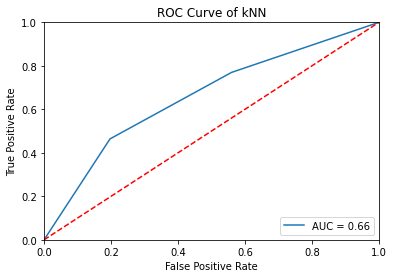

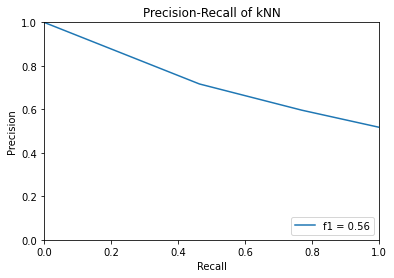

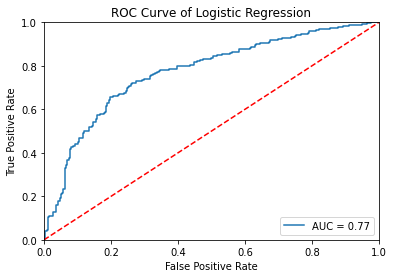

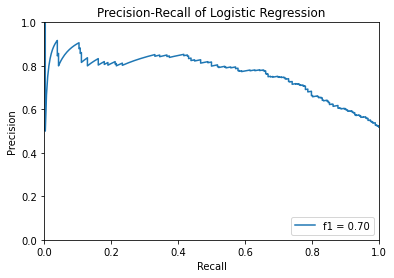

In [230]:
import vowpalwabbit
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import auc, f1_score
import matplotlib.pyplot as plt

X = final[["A", "T", "G", "C", "gc", "skew", "shannon", "melting_temp", "molecular_weight"]]
# Receptor 1, Ligand 0
Y = final["type"].transform(lambda x: 1 if x == "RECEPTOR" else 0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.35)

# KNN
model = KNeighborsClassifier(2)
model.fit(X_train, Y_train)

predictions = model.predict(X_test)
probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
precision, recall, threshold = precision_recall_curve(Y_test, probs)
roc_auc = auc(fpr, tpr)
f1 = f1_score(Y_test, predictions)

plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

plt.plot(recall, precision, label = 'f1 = %0.2f' % f1)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall of kNN')
plt.show()


# Logistic Reg
reg = LogisticRegression(max_iter=3000)
reg.fit(X_train, Y_train)

preds = reg.predict(X_test)
probs = reg.predict_proba(X_test)[:, 1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = auc(fpr, tpr)

precision, recall, threshold = precision_recall_curve(Y_test, probs)
f1 = f1_score(Y_test, preds)

plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Logistic Regression')
plt.show()

plt.plot(recall, precision, label = 'f1 = %0.2f' % f1)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall of Logistic Regression')
plt.show()